# **Predicting League of Legends Match Outcomes Based on Team Composition**
###By: Tyler Anderson<br><hr>
About this project:<br>
This project is used to predict the outcome of a League of Legends game solely using the champion compositions of the two opposing teams. The purpose behind this concept is to give players insight towards optimal team compositions that could be used during the draft phase of a match, in an attempt to increase their likelihood of winning the game. Though a player only has control over their own champion selection, knowledge is power, and it's my hope that a little extra insight may lead to players selection champions which best suit their teams composition and improve the likelihood of winning the game.

The data used in this project is collected from the Riot Developer API, using descending match IDs from the North American and Western European game servers. This dataset is as close to current as I was able to manage for April 2023.

In [ ]:
## Import Libraries Requried for Project
import tensorflow as tf
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, Conv2D, InputLayer
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import datetime

In [ ]:
## Load datasets
na_stats = pd.read_csv('https://github.com/tyganderson/League-of-Legends-Outcome-Prediction/raw/main/Data/NA_result.csv')
eu_stats = pd.read_csv('https://github.com/tyganderson/League-of-Legends-Outcome-Prediction/raw/main/Data/EU_result.csv')
champIds = pd.read_csv('https://github.com/tyganderson/League-of-Legends-Outcome-Prediction/raw/main/Data/championIds.csv')


# **Dataset Samples**<br>
Below are samples of the datasets used for this project.<br>
Each match in the dataset contains the following:

```
*   matchId - A unique identifier for the match. Used in the Riot Developer API to obtain match information
*   blue1 - Champion pick for top lane of Blue Team
*   blue2 - Champion pick for jungle of Blue Team
*   blue3 - Champion pick for mid lane of Blue Team
*   blue4 - Champion pick for bot lane of Blue Team
*   blue5 - Champion pick for support of Blue Team
*   red1 - Champion pick for top lane of Red Team
*   red2 - Champion pick for jungle of Red Team
*   red3 - Champion pick for mid lane of Red Team
*   red4 - Champion pick for bot lane of Red Team
*   red5 - Champion pick for support of Red Team
*   blueWin - Result of the match. 0 indicates Blue Team lost, 1 indicates Blue Team won.
```

### Example of North American dataset

In [ ]:
# Display head of North American dataset
display(na_stats.head())

,matchId,blue1,blue2,blue3,blue4,blue5,red1,red2,red3,red4,red5,blueWin
0,NA1_4619747330,Gnar,Hecarim,Yasuo,Kaisa,Velkoz,Illaoi,Nocturne,Ekko,Tristana,Lux,0
1,NA1_4619747324,Seraphine,Tristana,Teemo,Jinx,Jhin,Ezreal,Nasus,Ryze,Alistar,Galio,1
2,NA1_4619747323,Malphite,Udyr,Katarina,Twitch,Pyke,Tryndamere,MasterYi,Akshan,Jinx,Yuumi,0
3,NA1_4619747321,Neeko,LeeSin,Talon,KogMaw,Yuumi,Riven,Kindred,Qiyana,Nilah,Malphite,0
4,NA1_4619747318,Mordekaiser,Vi,Tryndamere,Sivir,Renata,Darius,Volibear,Rumble,Ezreal,Thresh,0


### Example of Western European dataset

In [ ]:
# Display head of Western European dataset
display(eu_stats.head())

,matchId,blue1,blue2,blue3,blue4,blue5,red1,red2,red3,red4,red5,blueWin
0,EUW1_6349620651,Ekko,Twitch,Lux,Illaoi,MasterYi,Sett,MissFortune,Warwick,Ahri,Seraphine,1
1,EUW1_6349620650,Sion,Shyvana,Sylas,Sivir,Yuumi,Teemo,Viego,TwistedFate,Kalista,Blitzcrank,1
2,EUW1_6349620649,Riven,Warwick,Sylas,Nilah,Yuumi,Vi,Amumu,Caitlyn,Jinx,Seraphine,1
3,EUW1_6349620646,MissFortune,Quinn,Tristana,Corki,Ezreal,Ezreal,Nasus,Ryze,Alistar,Galio,1
4,EUW1_6349620645,Seraphine,Ezreal,AurelionSol,LeeSin,Riven,Jayce,Katarina,Nami,Zac,Nilah,0


# **Charts for Champion Frequencies**<br>
Some champions are more popular than others, and therefore are more commonly selected for a given match. This results in more matches featuring these champions, and less matches with less popular champions.

Below are charts showing the 20 *most* common champion picks for each role, with separate charts for datasets from each region (North America and Western Europe)

<Axes: title={'center': '20 Most Common Support Picks (EU)'}>

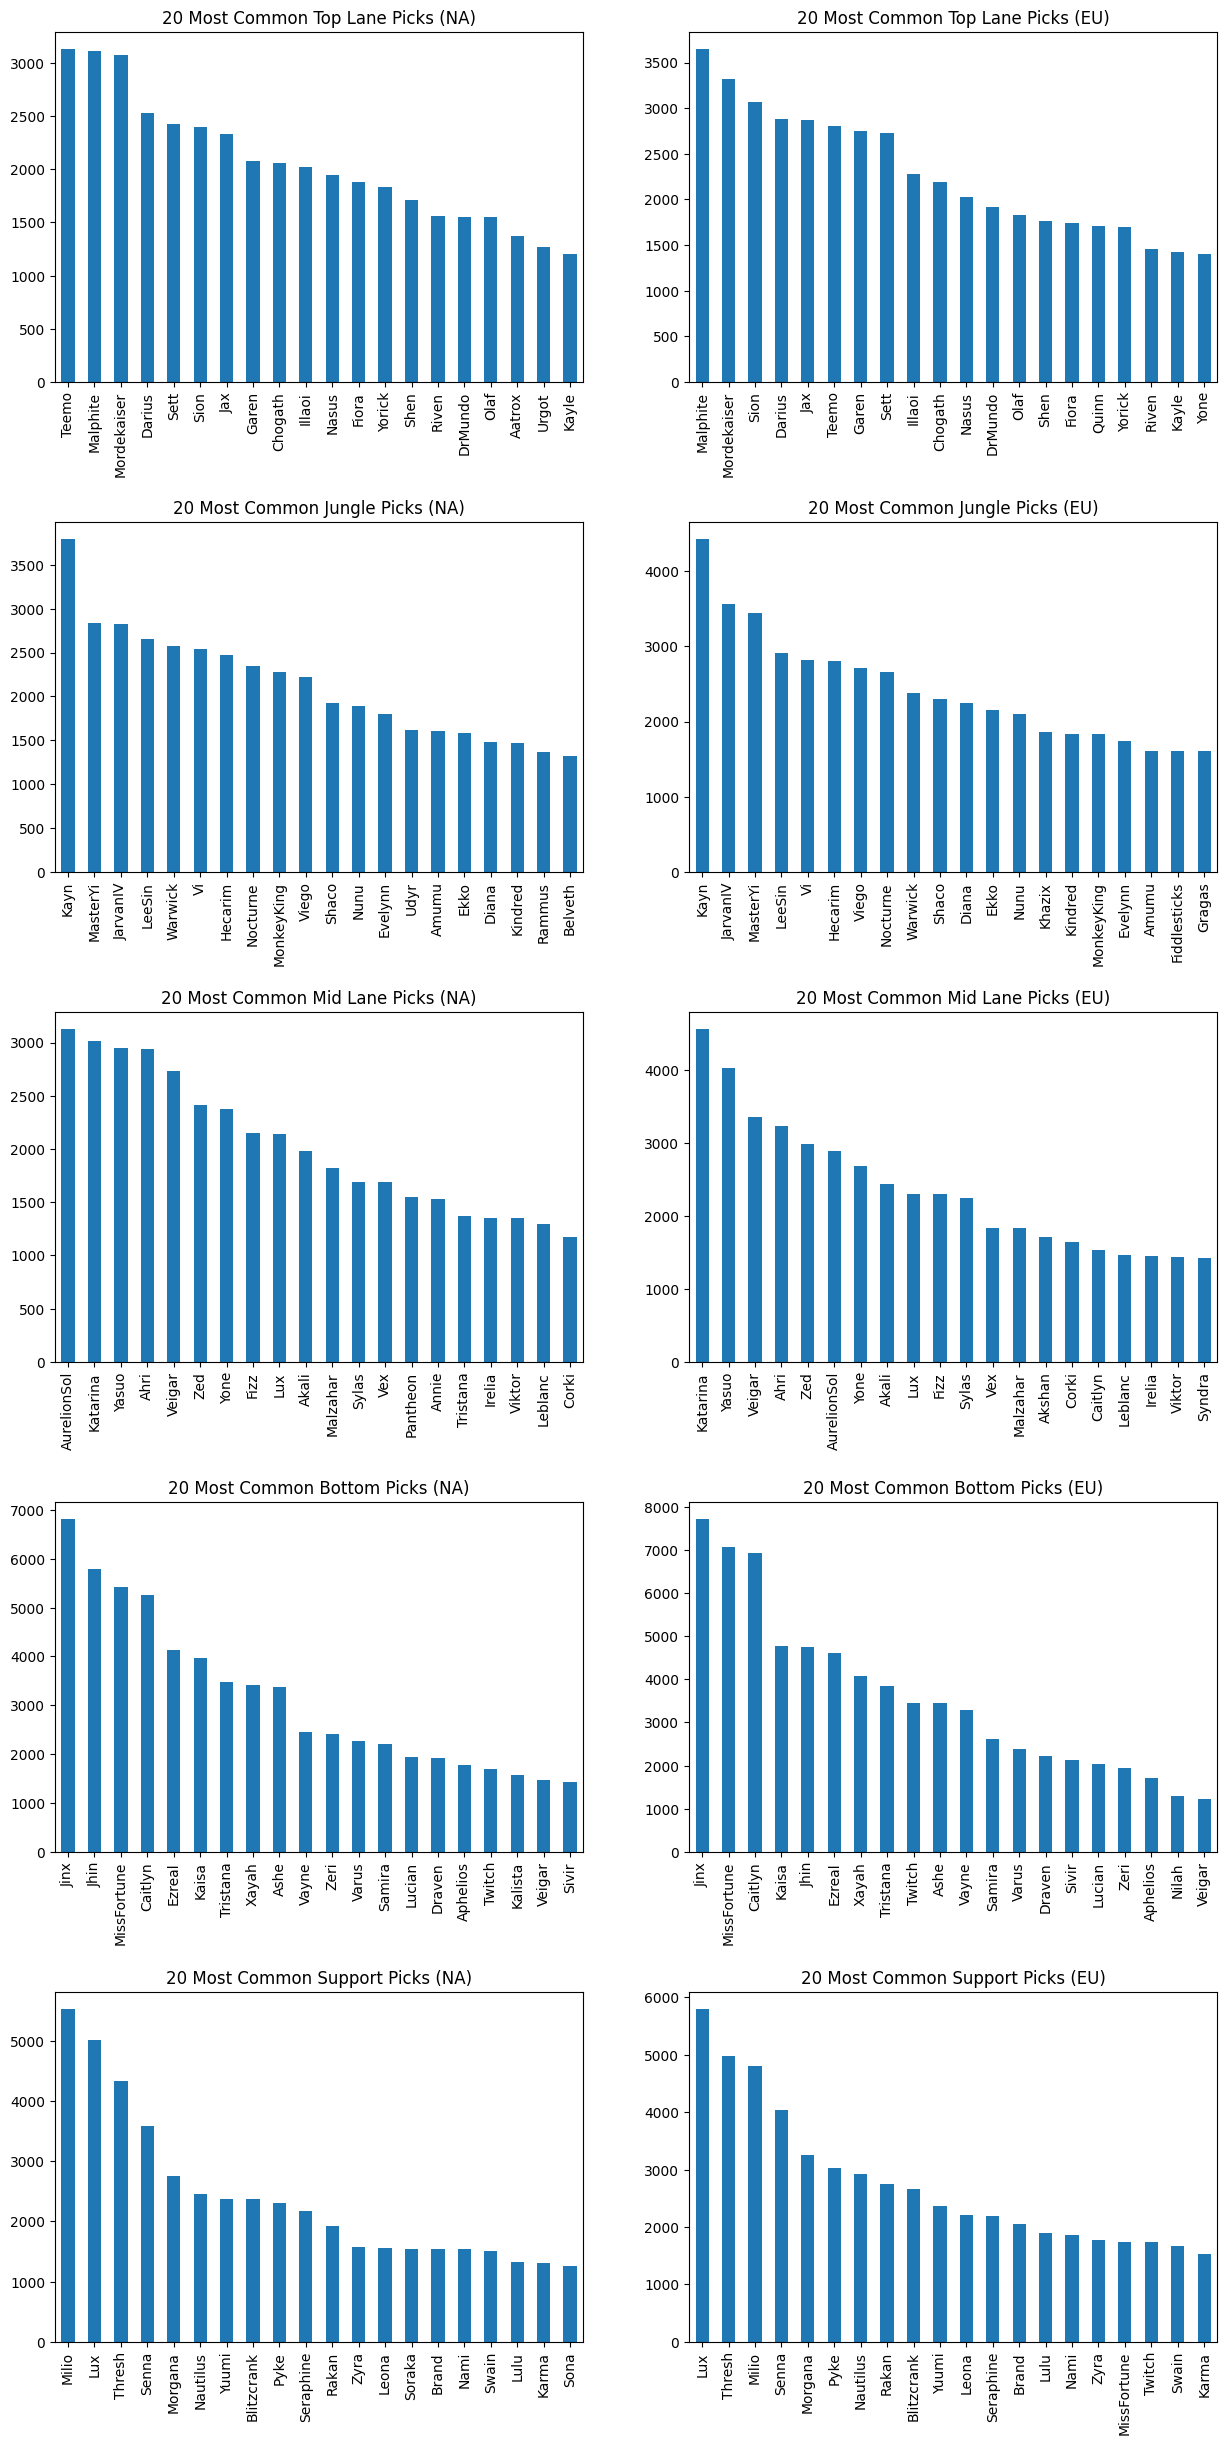

In [ ]:
## Charts!
import matplotlib.pyplot as plt

# Configure plot sizes & spacing
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
plt.subplots_adjust(hspace=0.4)

# Add plots of top 20 champions for each role in NA
na_stats.blue1.value_counts()[:20].plot(ax=axes[0,0], title='20 Most Common Top Lane Picks (NA)', kind='bar')
na_stats.blue2.value_counts()[:20].plot(ax=axes[1,0], title='20 Most Common Jungle Picks (NA)', kind='bar')
na_stats.blue3.value_counts()[:20].plot(ax=axes[2,0], title='20 Most Common Mid Lane Picks (NA)', kind='bar')
na_stats.blue4.value_counts()[:20].plot(ax=axes[3,0], title='20 Most Common Bottom Picks (NA)', kind='bar')
na_stats.blue5.value_counts()[:20].plot(ax=axes[4,0], title='20 Most Common Support Picks (NA)', kind='bar')

# Add plots of top 20 champions for each role in EU
eu_stats.blue1.value_counts()[:20].plot(ax=axes[0,1], title='20 Most Common Top Lane Picks (EU)', kind='bar')
eu_stats.blue2.value_counts()[:20].plot(ax=axes[1,1], title='20 Most Common Jungle Picks (EU)', kind='bar')
eu_stats.blue3.value_counts()[:20].plot(ax=axes[2,1], title='20 Most Common Mid Lane Picks (EU)', kind='bar')
eu_stats.blue4.value_counts()[:20].plot(ax=axes[3,1], title='20 Most Common Bottom Picks (EU)', kind='bar')
eu_stats.blue5.value_counts()[:20].plot(ax=axes[4,1], title='20 Most Common Support Picks (EU)', kind='bar')

The below charts instead show the 20 *least* common champion picks for each role, with separate charts for datasets from each region (North America and Western Europe)

<Axes: title={'center': '20 Least Common Support Picks (EU)'}>

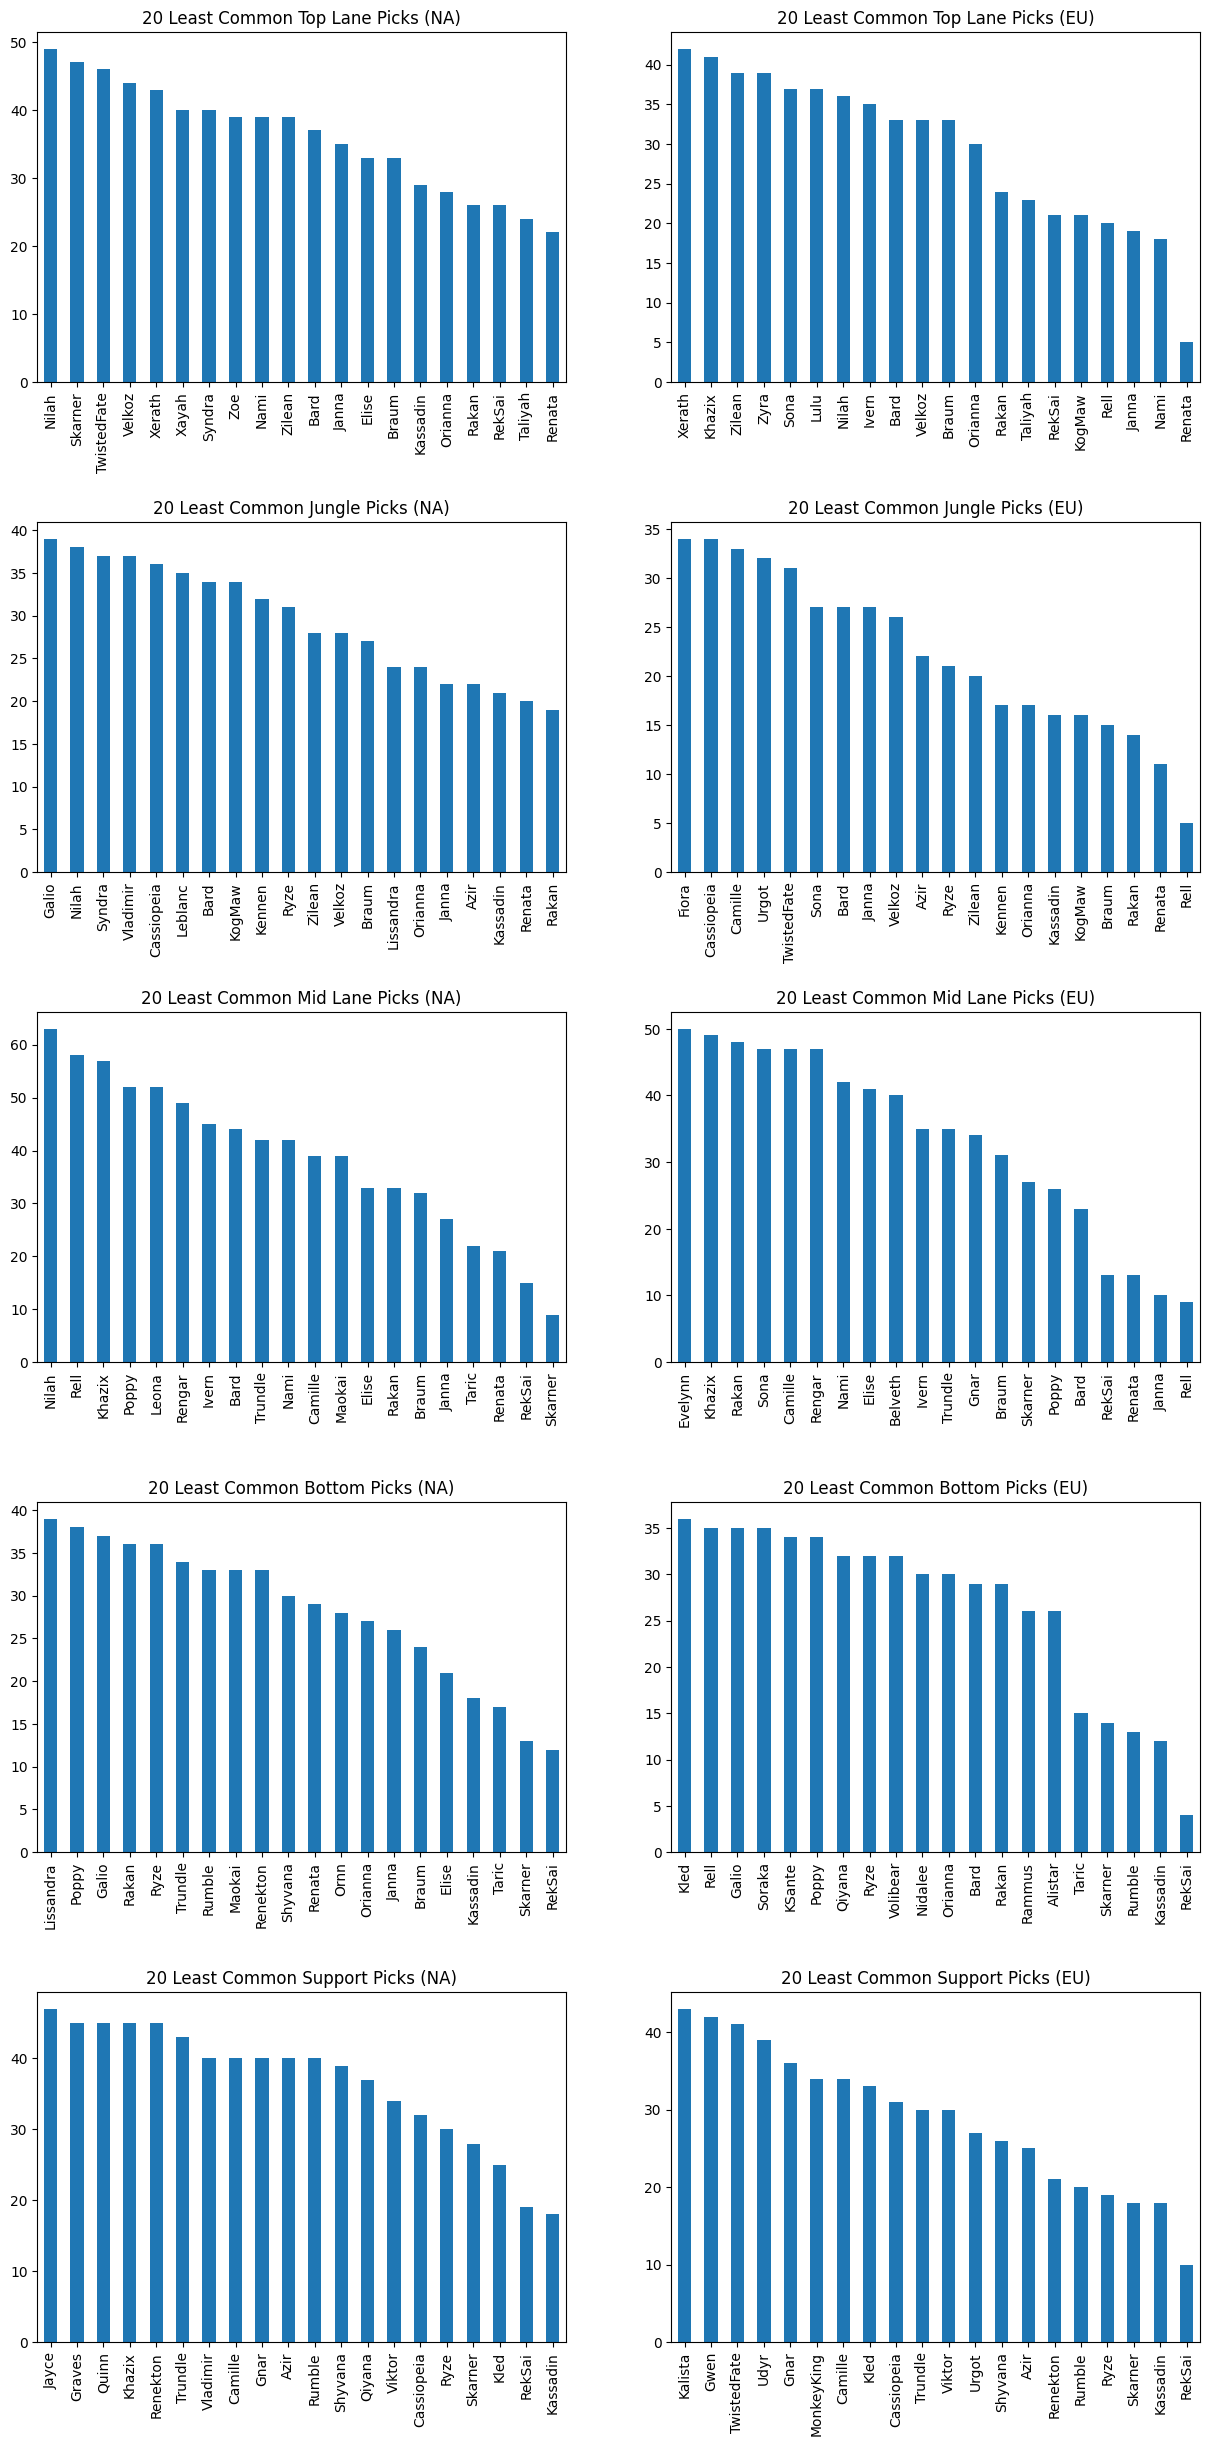

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,30))
plt.subplots_adjust(hspace=0.4)

# Add plots of bottom 20 champions for each role in NA
na_stats.blue1.value_counts()[-20:].plot(ax=axes[0,0], title='20 Least Common Top Lane Picks (NA)', kind='bar')
na_stats.blue2.value_counts()[-20:].plot(ax=axes[1,0], title='20 Least Common Jungle Picks (NA)', kind='bar')
na_stats.blue3.value_counts()[-20:].plot(ax=axes[2,0], title='20 Least Common Mid Lane Picks (NA)', kind='bar')
na_stats.blue4.value_counts()[-20:].plot(ax=axes[3,0], title='20 Least Common Bottom Picks (NA)', kind='bar')
na_stats.blue5.value_counts()[-20:].plot(ax=axes[4,0], title='20 Least Common Support Picks (NA)', kind='bar')

# Add plots of bottom 20 champions for each role in EU
eu_stats.blue1.value_counts()[-20:].plot(ax=axes[0,1], title='20 Least Common Top Lane Picks (EU)', kind='bar')
eu_stats.blue2.value_counts()[-20:].plot(ax=axes[1,1], title='20 Least Common Jungle Picks (EU)', kind='bar')
eu_stats.blue3.value_counts()[-20:].plot(ax=axes[2,1], title='20 Least Common Mid Lane Picks (EU)', kind='bar')
eu_stats.blue4.value_counts()[-20:].plot(ax=axes[3,1], title='20 Least Common Bottom Picks (EU)', kind='bar')
eu_stats.blue5.value_counts()[-20:].plot(ax=axes[4,1], title='20 Least Common Support Picks (EU)', kind='bar')

# **One-hot encoding**<br>
To categorically represent each player's champion selection as our input to the model, we perform one-hot encoding on each champion picked. Since there are a total of 163 champions at the time of this project, each champion selection will be converted to a 1-dimensional array consisting of 162 0's and a single 1, with the 1 representing the champion selected. As an example:

```
The champion Aatrox is represented by the following array:
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
The champion Lux is represented by the following array:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
```

The one-hot encodings for all 10 players are then concatenated to a single 1-dimensional array of length 1630.

This process is separated by the North American dataset and the Western European dataset, allowing for easy swapping between datasets used for the model (trying individual regions, or the combination of both).

## Combined inputs list
To isolate the training and testing to a single dataset, only run one of the 2 cells created for one-hot encoding the regional datasets. Each cell, when ran, will concat its data to the X and y variables

In [ ]:
X = []
y = []

#### One-hot encoding for North American dataset

In [ ]:
## Create X and y variables for na_stats
X1 = na_stats[na_stats.columns[1:11]]
y1 = na_stats['blueWin'].tolist()

## Convert X1 to one-hot encoding
blue1_onehot = pd.get_dummies(X1.blue1).values
blue2_onehot = pd.get_dummies(X1.blue2).values
blue3_onehot = pd.get_dummies(X1.blue3).values
blue4_onehot = pd.get_dummies(X1.blue4).values
blue5_onehot = pd.get_dummies(X1.blue5).values

red1_onehot = pd.get_dummies(X1.red1).values
red2_onehot = pd.get_dummies(X1.red2).values
red3_onehot = pd.get_dummies(X1.red3).values
red4_onehot = pd.get_dummies(X1.red4).values
red5_onehot = pd.get_dummies(X1.red5).values

X1 = []

for i in range(len(blue1_onehot)):
  index = []
  index.append(blue1_onehot[i])
  index.append(blue2_onehot[i])
  index.append(blue3_onehot[i])
  index.append(blue4_onehot[i])
  index.append(blue5_onehot[i])
  index.append(red1_onehot[i])
  index.append(red2_onehot[i])
  index.append(red3_onehot[i])
  index.append(red4_onehot[i])
  index.append(red5_onehot[i])
  index = np.asarray(index)
  index = index.flatten()
  X.append(index)
  X1.append(index)

# Add labels to y
y = np.concatenate((y, y1))

#### One-hot encoding for Western European dataset

In [ ]:
## Create X and y variables for eu_stats
X2 = eu_stats[eu_stats.columns[1:11]]
y2 = eu_stats['blueWin'].tolist()

## Convert X2 to one-hot encoding
blue1_onehot = pd.get_dummies(X2.blue1).values
blue2_onehot = pd.get_dummies(X2.blue2).values
blue3_onehot = pd.get_dummies(X2.blue3).values
blue4_onehot = pd.get_dummies(X2.blue4).values
blue5_onehot = pd.get_dummies(X2.blue5).values

red1_onehot = pd.get_dummies(X2.red1).values
red2_onehot = pd.get_dummies(X2.red2).values
red3_onehot = pd.get_dummies(X2.red3).values
red4_onehot = pd.get_dummies(X2.red4).values
red5_onehot = pd.get_dummies(X2.red5).values

X2 = []

for i in range(len(blue1_onehot)):
  index = []
  index.append(blue1_onehot[i])
  index.append(blue2_onehot[i])
  index.append(blue3_onehot[i])
  index.append(blue4_onehot[i])
  index.append(blue5_onehot[i])
  index.append(red1_onehot[i])
  index.append(red2_onehot[i])
  index.append(red3_onehot[i])
  index.append(red4_onehot[i])
  index.append(red5_onehot[i])
  index = np.asarray(index)
  index = index.flatten()
  X.append(index)
  X2.append(index)

# Add labels to y
y = np.concatenate((y, y2))

# **Bias in the data**<br>
According to the game developers of League of Legends, there is a general bias in the match results that favor the Blue Team, with the Blue Team having an approximate 55% overall winrate.

To ensure our data is accurate to this pre-established bias in the game, we calculate the number of entries in our dataset where the Blue Team lost, as well as the number of entries where the Blue Team won, and determine the overall winrate of the Blue Team for our data.

As can be seen below, our results indicate a ~55.6% bias for the Blue Team winning, which closely resembles the inherent bias in the game. This serves as a good evaluation point, where random guessing for which team wins should result in the same accuracy.

In [ ]:
# Evaluate the overall winrate of Blue Team in the given dataset
losses = 0
wins = 0

for i in y:
  if i == 0:
    losses += 1
  if i == 1:
    wins += 1

print('Number of blue team losses:', losses)
print('Number of blue team wins:', wins)
print('Average win-rate of blue team:', wins / (wins + losses))

Number of blue team losses: 77079
Number of blue team wins: 96702
Average win-rate of blue team: 0.5564589914892882


# **Splitting the dataset**<br>
For this project, our data is split as follows:

*   80% Training
*   20% Testing

Both the training and testing splits are randomized. Evaluations metrics are reported only on the testing split.




### Combined Dataset

In [ ]:
# Build training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors for model training
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_test)
y_val = tf.convert_to_tensor(y_test)

### Only North American Dataset

In [ ]:
# Build training and testing datasets
X_train_NA, X_test_NA, y_train_NA, y_test_NA = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Convert to tensors for model training
X_train_NA = tf.convert_to_tensor(X_train_NA)
y_train_NA = tf.convert_to_tensor(y_train_NA)
X_val_NA = tf.convert_to_tensor(X_test_NA)
y_val_NA = tf.convert_to_tensor(y_test_NA)

### Only Western European Dataset

In [ ]:
# Build training and testing datasets
X_train_EU, X_test_EU, y_train_EU, y_test_EU = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Convert to tensors for model training
X_train_EU = tf.convert_to_tensor(X_train_EU)
y_train_EU = tf.convert_to_tensor(y_train_EU)
X_val_EU = tf.convert_to_tensor(X_test_EU)
y_val_EU = tf.convert_to_tensor(y_test_EU)

# **Creating our Models**<br>
The model used for evaluation of this project is a Dense Neural Network using the Keras library. The input to the model is a 1-d array of size 1630, composed of the one-hot encodings of the 10 players' champion selections. The sequence of layers after the input is as follows:

1.    Dense Layer - 300 nodes
2.    ReLU Activation
3.    Dropout - 20% rate
4.    Dense Layer - 200 nodes
5.    ReLU Activation
6.    Dropout - 20% rate
7.    Dense Layer - 100 nodes
8.    ReLU Activation
9.    Dropout - 20% rate
10.   Dense Layer - 1 node
11.   Sigmoid Activation

This model's loss function is Binary Cross Entropy.<br>
This model's opitmizer is Adam.</br>
During model fitting, accuracy and loss metrics will be displayed for each epoch.


In [ ]:
def getModel():

  model = Sequential()
  model.add(InputLayer(input_shape=(1630,)))
  model.add(Dense(300, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(200, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(100, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss=BinaryCrossentropy(),
                  optimizer = Adam(learning_rate=1e-4),
                  metrics = ['accuracy'])

  return model

### Test combined model


In [ ]:
# Get new, untrained model
model = getModel()

# Fit model to the data
history = model.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val), batch_size=100)

# Evaluate model on combined data
model1_predictions = model.predict(X_val)
for i in range(len(model1_predictions)):
  if model1_predictions[i][0] >= 0.5:
    model1_predictions[i][0] = 1
  else:
    model1_predictions[i][0] = 0

# Display results
model1_f1score = f1_score(y_test, model1_predictions, average='macro')
model1_accuracy = accuracy_score(y_test, model1_predictions)
print('===== Metrics for Combined Region Model =====')
print('F1 Score: ', model1_f1score)
print('Accuracy: ', model1_accuracy)

Epoch 1/20
1391/1391 [==============================] - 9s 4ms/step - loss: 0.6361 - accuracy: 0.5747 - val_loss: 0.6232 - val_accuracy: 0.5980
Epoch 2/20
1391/1391 [==============================] - 5s 4ms/step - loss: 0.6128 - accuracy: 0.6199 - val_loss: 0.6143 - val_accuracy: 0.6182
Epoch 3/20
1391/1391 [==============================] - 6s 4ms/step - loss: 0.5910 - accuracy: 0.6536 - val_loss: 0.6062 - val_accuracy: 0.6335
Epoch 4/20
1391/1391 [==============================] - 7s 5ms/step - loss: 0.5609 - accuracy: 0.6907 - val_loss: 0.5961 - val_accuracy: 0.6550
Epoch 5/20
1391/1391 [==============================] - 5s 4ms/step - loss: 0.5218 - accuracy: 0.7273 - val_loss: 0.5928 - val_accuracy: 0.6621
Epoch 6/20
1391/1391 [==============================] - 6s 4ms/step - loss: 0.4841 - accuracy: 0.7556 - val_loss: 0.5873 - val_accuracy: 0.6731
Epoch 7/20
1391/1391 [==============================] - 6s 4ms/step - loss: 0.4493 - accuracy: 0.7789 - val_loss: 0.5900 - val_accuracy:

### Test North American Model

In [ ]:
# Get new, untrained model
model_NA = getModel()

# Fit model to the data
history_NA = model_NA.fit(x=X_train_NA, y=y_train_NA, validation_data=(X_val_NA, y_val_NA), epochs=20, batch_size=100)

# Evaluate model on combined data
model2_predictions = model_NA.predict(X_val_NA)
for i in range(len(model2_predictions)):
  if model2_predictions[i][0] >= 0.5:
    model2_predictions[i][0] = 1
  else:
    model2_predictions[i][0] = 0

# Display results
model2_f1score = f1_score(y_test_NA, model2_predictions, average='macro')
model2_accuracy = accuracy_score(y_test_NA, model2_predictions)
print('===== Metrics for North American Model =====')
print('F1 Score: ', model2_f1score)
print('Accuracy: ', model2_accuracy)

Epoch 1/20
654/654 [==============================] - 3s 4ms/step - loss: 0.6523 - accuracy: 0.5556 - val_loss: 0.6424 - val_accuracy: 0.5645
Epoch 2/20
654/654 [==============================] - 2s 3ms/step - loss: 0.6304 - accuracy: 0.5879 - val_loss: 0.6378 - val_accuracy: 0.5703
Epoch 3/20
654/654 [==============================] - 3s 5ms/step - loss: 0.6198 - accuracy: 0.6132 - val_loss: 0.6393 - val_accuracy: 0.5755
Epoch 4/20
654/654 [==============================] - 2s 4ms/step - loss: 0.6067 - accuracy: 0.6351 - val_loss: 0.6441 - val_accuracy: 0.5777
Epoch 5/20
654/654 [==============================] - 2s 4ms/step - loss: 0.5908 - accuracy: 0.6557 - val_loss: 0.6536 - val_accuracy: 0.5793
Epoch 6/20
654/654 [==============================] - 2s 4ms/step - loss: 0.5681 - accuracy: 0.6819 - val_loss: 0.6664 - val_accuracy: 0.5747
Epoch 7/20
654/654 [==============================] - 3s 4ms/step - loss: 0.5400 - accuracy: 0.7111 - val_loss: 0.6857 - val_accuracy: 0.5717
Epoch 

### Test Western European Model

In [ ]:
# Get new, untrained model
model_EU = getModel()

# Fit model to the data
history_EU = model_EU.fit(x=X_train_EU, y=y_train_EU, validation_data=(X_val_EU, y_val_EU), epochs=20, batch_size=100)

# Evaluate model on combined data
model3_predictions = model_EU.predict(X_val_EU)
for i in range(len(model3_predictions)):
  if model3_predictions[i][0] >= 0.5:
    model3_predictions[i][0] = 1
  else:
    model3_predictions[i][0] = 0

# Display results
model3_f1score = f1_score(y_test_EU, model3_predictions, average='macro')
model3_accuracy = accuracy_score(y_test_EU, model3_predictions)
print('===== Metrics for Western European Model =====')
print('F1 Score: ', model3_f1score)
print('Accuracy: ', model3_accuracy)

Epoch 1/20
737/737 [==============================] - 4s 4ms/step - loss: 0.6321 - accuracy: 0.5865 - val_loss: 0.6123 - val_accuracy: 0.6229
Epoch 2/20
737/737 [==============================] - 3s 4ms/step - loss: 0.5912 - accuracy: 0.6513 - val_loss: 0.5852 - val_accuracy: 0.6673
Epoch 3/20
737/737 [==============================] - 3s 4ms/step - loss: 0.5443 - accuracy: 0.7070 - val_loss: 0.5485 - val_accuracy: 0.7066
Epoch 4/20
737/737 [==============================] - 3s 4ms/step - loss: 0.4781 - accuracy: 0.7633 - val_loss: 0.5068 - val_accuracy: 0.7488
Epoch 5/20
737/737 [==============================] - 3s 4ms/step - loss: 0.4106 - accuracy: 0.8076 - val_loss: 0.4784 - val_accuracy: 0.7757
Epoch 6/20
737/737 [==============================] - 3s 4ms/step - loss: 0.3556 - accuracy: 0.8406 - val_loss: 0.4622 - val_accuracy: 0.7878
Epoch 7/20
737/737 [==============================] - 3s 4ms/step - loss: 0.3113 - accuracy: 0.8652 - val_loss: 0.4587 - val_accuracy: 0.7973
Epoch 

# Model Evaluations
Each model is evaluated on the Accuracy and F1 Score of the 20% held-out validation set.
<br>Evaluations metrics were calculated using the scikit-learn metrics library.
<br>Plots of the model accuracies on the validation set are displayed from information gathered during the fitting of each model. For easier comparison, all 3 accuracy plots are displayed on the same chart.
<br>Plots of each model's loss during training is displayed separately, for clear separation of each model's training loss and validation loss.

===== Metrics for Combined Region Model =====
F1 Score:  0.6926928734727444
Accuracy:  0.6945363523894468

===== Metrics for North American Model =====
F1 Score:  0.5586673961464076
Accuracy:  0.561398139079334

===== Metrics for Western European Model =====
F1 Score:  0.809829250068235
Accuracy:  0.8128223223494925

 ---------------------------------------------


 Accuracy plots of models on validation set



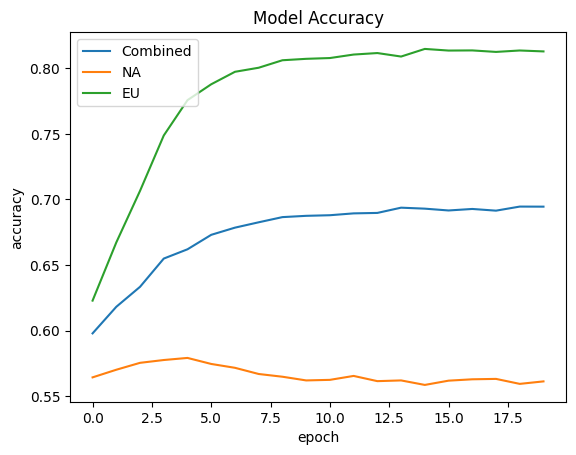


 Loss plots of models on during fitting



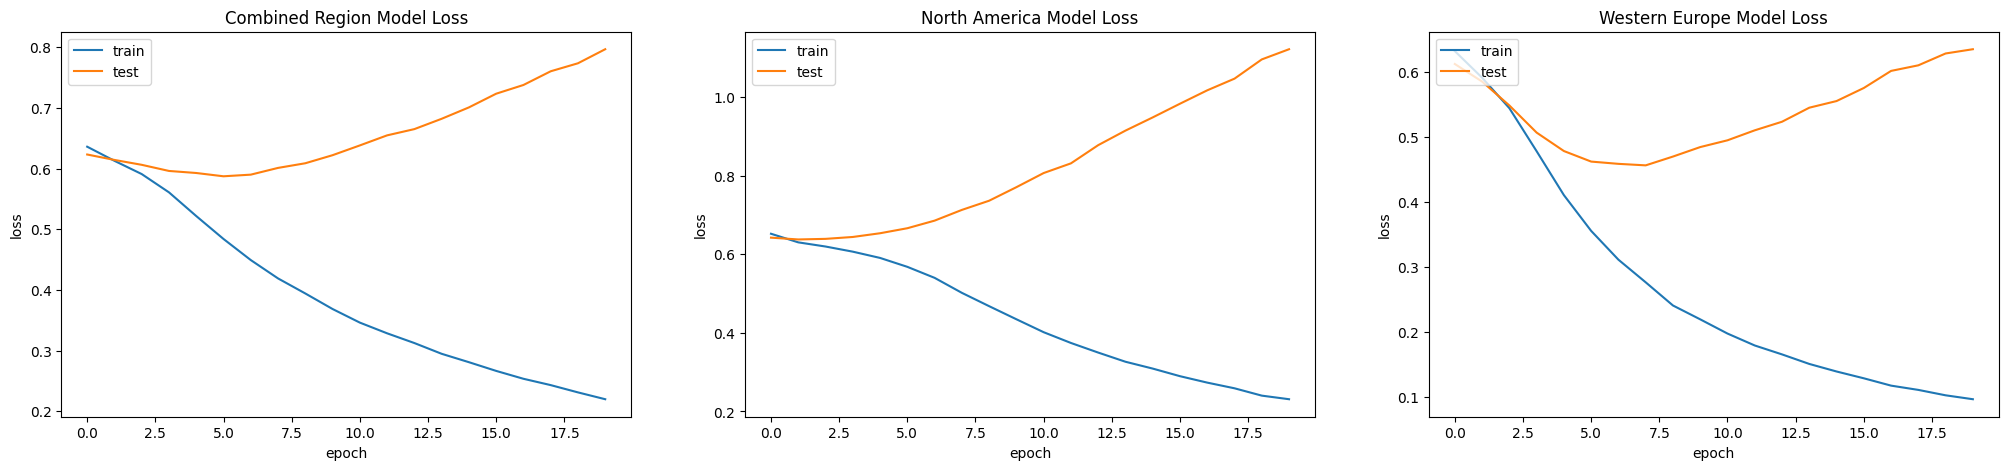

In [ ]:
print('===== Metrics for Combined Region Model =====')
print('F1 Score: ', model1_f1score)
print('Accuracy: ', model1_accuracy)

print('\n===== Metrics for North American Model =====')
print('F1 Score: ', model2_f1score)
print('Accuracy: ', model2_accuracy)

print('\n===== Metrics for Western European Model =====')
print('F1 Score: ', model3_f1score)
print('Accuracy: ', model3_accuracy)

# Header for accuracy plot
print('\n ---------------------------------------------\n')
print('\n Accuracy plots of models on validation set\n')

# Display accuracies of each model
plt.plot(history.history['val_accuracy'])
plt.plot(history_NA.history['val_accuracy'])
plt.plot(history_EU.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Combined', 'NA', 'EU'], loc='upper left')
plt.show()

# Header for loss plots
print('\n Loss plots of models on during fitting\n')

# Configure subplots for loss plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
plt.subplots_adjust(hspace=0.4)

# Subplot for Combined Region
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Combined Region Model Loss')
axes[0].set(xlabel='epoch', ylabel='loss')
axes[0].legend(['train', 'test'], loc='upper left')

# Subplot for North America
axes[1].plot(history_NA.history['loss'])
axes[1].plot(history_NA.history['val_loss'])
axes[1].set_title('North America Model Loss')
axes[1].set(xlabel='epoch', ylabel='loss')
axes[1].legend(['train', 'test'], loc='upper left')

# Subplot for Western Europe
axes[2].plot(history_EU.history['loss'])
axes[2].plot(history_EU.history['val_loss'])
axes[2].set_title('Western Europe Model Loss')
axes[2].set(xlabel='epoch', ylabel='loss')
axes[2].legend(['train', 'test'], loc='upper left')
plt.show()